<a href="https://colab.research.google.com/github/amishra06/Identify-Characters-from-Product-Images/blob/master/Identify_Characters_from_Product_Images_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##  Identifying Characters from Product Images

Goal is to Identify the “characters” from each image from a list of  42 possible characters.

Data set consists of product images like t-shirts, bags, keychains, mobile covers, etc. with characters graphics. The master data set has been split into training and test data sets for the contest tasks. 






**Importing modules**

I am using fastai for this multi class image classification problem.

In [0]:
from fastai import *
from fastai.vision import *
import os as os
from os import *
import random
from PIL import Image
from PIL import ImageFilter

**Arranging the Data**

Created the top folder named *Characters*, under that copyied the zipped  training data file and unzipped it. After unzipping, *CAX_Characters_Train* folder gets created. Under this folder there are subfolders whose names are class labels for particular set of product images and those images are under that class label subfolder. So we need to pick the class labels from these subfolders names

In [0]:
# Working on google colab
#path = Path('gdrive/My Drive/Colab Notebooks/Game of Deep Learning')
path = Path('Characters')
dest = path
dest.mkdir(parents=True, exist_ok=True)
#dest.rmdir()

In [0]:
!mv Train.zip Characters/
!unzip -d Characters Characters/Train.zip

In [0]:
flist=(path/'CAX_Characters_Train').ls()
classes = [os.path.basename(f) for f in flist]

In [0]:
classes

Checking if training data is balanced or not. We can see the there just 78 images for *squirtle* where as there are 428 images for *jojosiwa*.

In [0]:
# Creating a dictionary with class subfolder path and count of files in it, so that I can sort class subfolder path based on, no of files.
filelist = {}
for dirpath, dirnames, filenames in os.walk(path/'CAX_Characters_Train'):
    count = len(filenames)
    #print("Files in ", dirpath, count)
    if(count > 0):
        filelist.update({dirpath: count}) 
sorted(((v,k) for k,v in filelist.items()))

To balance the unbalanced training set, image files are augmented using python pillow module and saved in same location. 

In [0]:
# Get the class subfolder paths in list
classpaths = [] 
for i in filelist.keys():
    classpaths.append(i)

In [0]:
classpaths


In [17]:
#Augment the images and save them back in same folder
for cpath in classpaths:
    fullpath = '/content/' + cpath
    os.chdir(fullpath)
    cwd = os.getcwd()
    for imagefile in os.listdir(cwd):
        im=Image.open(imagefile)
        im=im.convert("RGB")
        im_blur=im.filter(ImageFilter.GaussianBlur)
        im_unsharp=im.filter(ImageFilter.UnsharpMask)
        im_blur.save('bl_'+imagefile)
        im_unsharp.save('un_'+imagefile)
        if(len(os.listdir(cwd)) >= 500):
            break

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


**Splitting the data in to train and validation set**

To work  with fastai's data block api we need to create validation set also. I am creating validation folder (Valid) in same  location where train set folder (CAX_Characters_Train) exists.  I am randomly shuffling the train set files and shifting 20 percent files to validation folder maintaining the same path structure as training data

In [0]:
# function to move the files to Valid folder
def copy_to_valid(chosen_files,class_dir):
    for i in range (len(chosen_files)):
        os.rename(path/'CAX_Characters_Train'/class_dir/chosen_files[i], path/'Valid'/class_dir/chosen_files[i])

In [0]:
# Go to each class folder and move 20% of files to Valid folder
for classname in classes:
    fpath = '/content/Characters'
    os.makedirs(f'{fpath}/Valid/{classname}', exist_ok=True)
    tpath = os.path.join(fpath, 'CAX_Characters_Train', classname)
    tpathfile = Path(tpath).ls()
    list_of_files = [os.path.basename(f) for f in tpathfile]
    random.shuffle(list_of_files)
    n_files_moved = int(len(list_of_files)*0.20)
    selected_files = [list_of_files[m] for m in range(n_files_moved)]
    copy_to_valid(selected_files,classname)

**Creation of databunch for training**

In [0]:
#Transform the image files 
tfms = get_transforms(max_rotate=25, xtra_tfms = [ squish(), ])

In [0]:
# create databunch for training
data = (ImageList.from_folder(path)
       .split_by_folder(train='CAX_Characters_Train', valid='Valid')
       .label_from_folder()
       .transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

In [0]:
x,y = data.train_ds[0]

Baloo


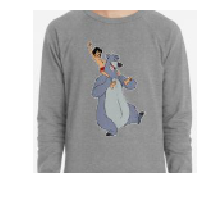

In [8]:
x.show()
print(y)

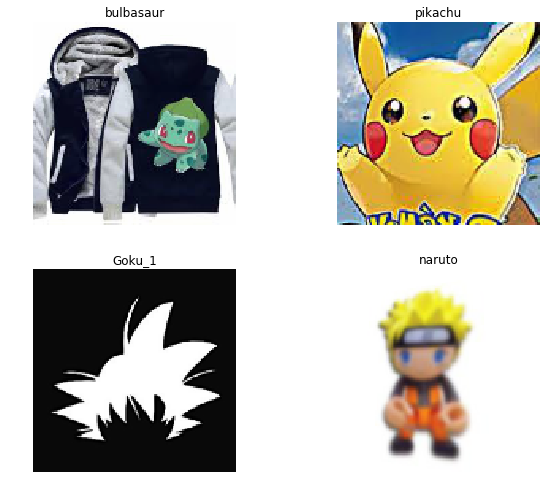

In [9]:
data.show_batch(rows=2, figsize=(9,7))

In [0]:
data.classes, len(data.classes), data.c, len(data.train_ds), len(data.valid_ds)


**Training**

*  I am creating the CNN learner
*  Using  transfer learning with resnet50.
* Training data with discriminative learning rate
* Initially starting with size 128 and then train with size 256




In [0]:
arch = models.resnet50

In [0]:
learn = cnn_learner(data, arch, metrics=[error_rate], wd=0.02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


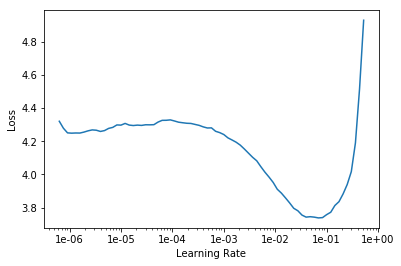

In [13]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01

In [15]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,2.342142,1.804326,0.492821,02:32
1,1.799702,1.413482,0.402310,02:30
2,1.590045,1.200478,0.349251,02:31
3,1.397443,1.048923,0.310549,02:29
4,1.211476,0.927749,0.279338,02:29
5,1.100452,0.777179,0.229401,02:28
6,0.949824,0.714364,0.211610,02:28
7,0.847513,0.628593,0.185393,02:29
8,0.722330,0.542738,0.160737,02:28
9,0.618436,0.462169,0.134207,02:28


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


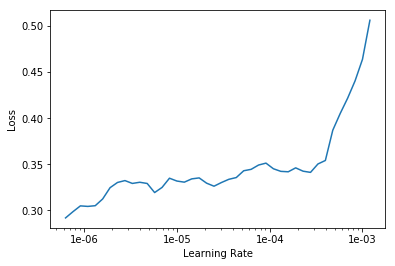

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.335582,0.335471,0.093945,02:36
1,0.315439,0.317709,0.088639,02:35
2,0.309778,0.310905,0.086142,02:35
3,0.264215,0.266489,0.078340,02:35
4,0.212789,0.240178,0.062422,02:35
5,0.176505,0.228476,0.063670,02:35
6,0.156244,0.217399,0.055556,02:36
7,0.128873,0.214039,0.056492,02:35
8,0.103841,0.208005,0.053371,02:37
9,0.105650,0.208260,0.053683,02:35


In [20]:
# checking the model after finishing training with size of 128
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

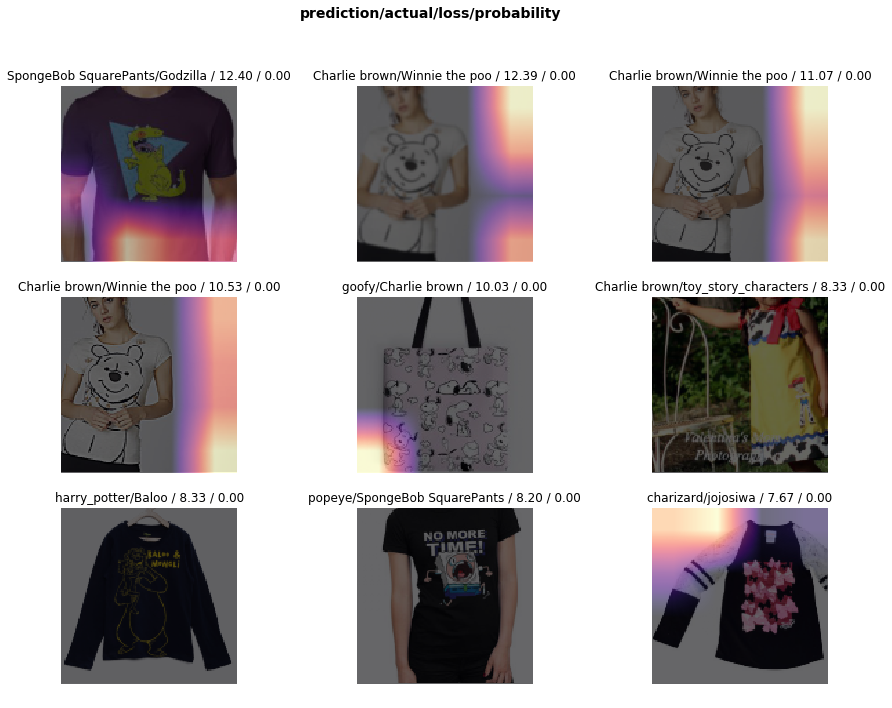

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.most_confused(min_val=2)

In [0]:
learn.save('stage-2')

In [0]:
learn.freeze()

In [25]:
# Creating databunh for size 256 and again start training the model
data = (ImageList.from_folder(path)
       .split_by_folder(train='CAX_Characters_Train', valid='Valid')
       .label_from_folder()
       .transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


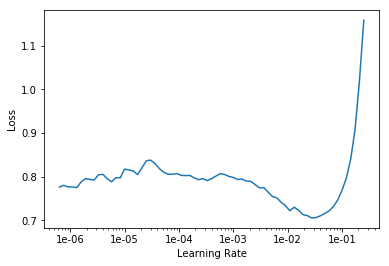

In [26]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-3

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.675315,0.456282,0.132959,04:42
1,0.460287,0.331251,0.094257,04:39
2,0.359207,0.286781,0.085830,04:39
3,0.307844,0.271408,0.081149,04:39
4,0.281114,0.270686,0.081461,04:41


In [0]:
learn.save('stage-3')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


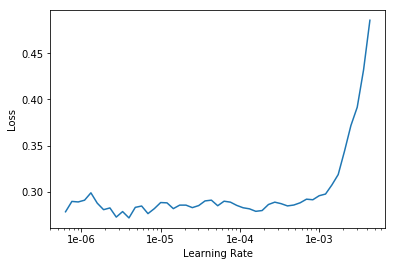

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, max_lr=slice(1e-6/2,1e-4/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.254906,0.261036,0.079276,05:56
1,0.261706,0.245548,0.072722,05:56
2,0.241164,0.231930,0.066792,05:57
3,0.214220,0.215775,0.059925,05:56
4,0.175896,0.202613,0.059613,05:57
5,0.170898,0.191005,0.053995,05:56
6,0.153212,0.187634,0.053683,05:55
7,0.152282,0.183783,0.051186,05:56
8,0.138630,0.185453,0.051186,05:56
9,0.146718,0.184330,0.051810,05:54


In [0]:
learn.save('stage-4')

In [0]:
learn.export()

**Prediction on test set**

In [0]:
!mv Test.zip Characters/
!unzip -d Characters Characters/Test.zip

In [0]:
test = (ImageList.from_folder(path/'test_characters_new'))

In [36]:
len(test)

3727

In [0]:
learn = load_learner(path, test=test)

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p == max(pred)]) for pred in preds]

In [0]:
fnames = [os.path.basename(f) for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'Filename':fnames, 'Prediction':labelled_preds}, columns=['Filename', 'Prediction'])

In [0]:
df.to_csv(path/'submission.csv', index=False)